# This notebook contains code for creating and evaluating logistic regression and random forest models

In [6]:
reset -fs

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,recall_score,precision_score,fbeta_score,make_scorer,roc_auc_score,roc_curve,confusion_matrix,precision_recall_curve,classification_report
from sklearn.feature_selection import SelectFromModel

import imblearn.over_sampling
import imblearn.under_sampling

from treeinterpreter import treeinterpreter as ti, utils

In [8]:
os.getcwd()

'/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project'

In [9]:
os.chdir('/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project')

## Read in dataset for modeling

In [10]:
subjects_incidents = pd.read_csv('nypd_force_df_rev2.csv')

In [11]:
subjects_incidents.columns

Index(['subject_id', 'tri_incident_number', 'subject_injury_level',
       'subject_injured', 'subject_age', 'subject_race', 'subject_gender',
       'force_against_mos', 'subject_used_force', 'occurrence_date',
       ...
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER',
       'member_injured_all_Y', 'race_diff_all_Y', 'race_diff_Y',
       'subject_injured_target'],
      dtype='object', length=101)

In [12]:
subjects_incidents['subject_injured_target'].value_counts()

0    31589
1      683
Name: subject_injured_target, dtype: int64

Drop rows with NaN in the subject age column, since logistic regression can't handle NaNs

In [13]:
subjects_incidents_no_null = subjects_incidents.dropna()

Create dataframe of features I'll actually use (plus subject_id and tri_incident_number, which are needed for splitting into train/val/split) and the target variable

In [14]:
df_X = subjects_incidents_no_null[['subject_id','tri_incident_number','subject_age',
                                   'num_subjects','num_members','race_diff_all_Y',
                                   'member_injured_all_Y',
       'member_injured_Y','race_diff_Y','subject_used_force_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER','subject_injured_target']]

## Model Preparation

In [15]:
# scale numeric features
cols_to_scale = ['num_members','num_subjects','subject_age']
scaler = StandardScaler()
df_X[cols_to_scale] = scaler.fit_transform(df_X[cols_to_scale])

/var/folders/39/jt9qcrmn79dgs0dxlm65sdn40000gn/T/ipykernel_70269/1532820943.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X[cols_to_scale] = scaler.fit_transform(df_X[cols_to_scale])


In [16]:
# split the data into train/validate/test sets with stratified sampling
    # to ensure the same proportion of the target variable in each set

# train-test split
X_train, X_te, y_train, y_te = train_test_split(df_X.iloc[:,1:], df_X['subject_injured_target'], test_size=0.2, stratify=df_X['subject_injured_target'], random_state=42)

# train-val split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=42)

In [17]:
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{df_X["subject_injured_target"].value_counts() / len(df_X)}\n\n'+
      f'PROPORTION OF TARGET IN THE TRAINING SET\n{y_tr.value_counts() / len(y_tr)}\n\n'+
      f'PROPORTION OF TARGET IN THE VALIDATION SET\n{y_val.value_counts() / len(y_val)}\n\n'+
      f'PROPORTION OF TARGET IN THE TEST SET\n{y_te.value_counts() / len(y_te)}')

PROPORTION OF TARGET IN THE ORIGINAL DATA
0    0.978603
1    0.021397
Name: subject_injured_target, dtype: float64

PROPORTION OF TARGET IN THE TRAINING SET
0    0.978581
1    0.021419
Name: subject_injured_target, dtype: float64

PROPORTION OF TARGET IN THE VALIDATION SET
0    0.978635
1    0.021365
Name: subject_injured_target, dtype: float64

PROPORTION OF TARGET IN THE TEST SET
0    0.978638
1    0.021362
Name: subject_injured_target, dtype: float64


In [145]:
# create a helper function that will allow me to cross-validate, plot an ROC curve,
    #calculate the ROC AUC score, and create confusion matrices

def cross_validate_roc_cm(model, X_train, y_train, X_validate, y_validate):
    
    scoring_metrics = {'f2_score': make_scorer(fbeta_score, beta=2),'rec': 'recall'}
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 42)
    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring_metrics)

    # Report results
    
    print(f"recall scores: {(cv_results['test_rec'])}")
    print("")
    print(f"mean recall: {(np.mean(cv_results['test_rec'])):.3f}")
    print("")
    print(f"f2 scores: {(cv_results['test_f2_score'])}")
    print("")
    print(f"mean f2 score: {(np.mean(cv_results['test_f2_score'])):.3f}")
    
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_validate, model.predict_proba(X_validate)[:,1]) # lr.predict_proba(X_validate)[:,1] means use probabilities for the positive outcome only

    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Model')

    # axis labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for injury')
    plt.legend()
    plt.show()
    print("ROC AUC score = ", roc_auc_score(y_validate, model.predict_proba(X_validate)[:,1]))
    
    # create and plot confusion matrix with training data
    con_mat = confusion_matrix(y_train, model.predict(X_train))
    plt.figure(dpi=80)
    sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

    plt.xlabel('Predicted injury')
    plt.ylabel('Actual injury')
    plt.title('Confusion Matrix - Training data')
    plt.show()
    
    # create and plot confusion matrix with validation data
    con_mat_val = confusion_matrix(y_validate, model.predict(X_validate))
    plt.figure(dpi=80)
    sns.heatmap(con_mat_val, cmap=plt.cm.Blues, annot=True, square=True)

    plt.xlabel('Predicted injury')
    plt.ylabel('Actual injury')
    plt.title('Confusion Matrix - Validation data')
    plt.show()

## Baseline Logistic Regression Model

Features: 
- subject's age
- whether member suffered an injury
- whether subject used force against member
- whether races of subject and member were different
- whether all members suffered an injury
- whether races of subject and all members are different
- force type
- basis for encounter
- patrol borough
- subject's gender
- subject's race
- member's race
- member's gender
- member's title/rank
- member's assignment

In [19]:
X_tr_1 = X_tr[['subject_age',
       'member_injured_Y','subject_used_force_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER']]

X_val_1 = X_val[['subject_age',
       'member_injured_Y','subject_used_force_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER']]

In [20]:
lr_base = LogisticRegression(solver='liblinear',max_iter=10000,random_state=42)
lr_base.fit(X_tr_1,y_tr)

LogisticRegression(max_iter=10000, random_state=42, solver='liblinear')

recall scores: [0.09210526 0.06741573 0.04347826 0.02531646 0.09195402]

mean recall: 0.064

f2 scores: [0.11254019 0.08241758 0.05263158 0.03125    0.11111111]

mean f2 score: 0.078


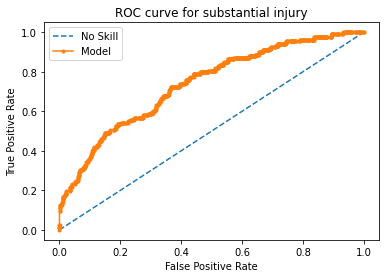

ROC AUC score =  0.7385175430368436


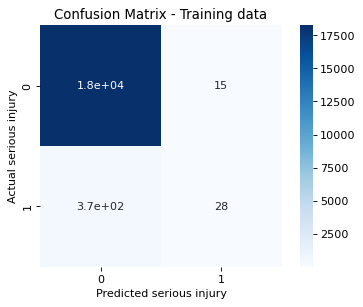

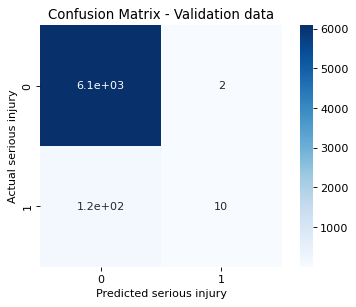

In [140]:
cross_validate_roc_cm(lr_base, X_tr_1,y_tr,X_val_1, y_val)

- LR base model: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR base model: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR base model: mean F2 score from cross-validation: .070

## LR Model 2 

Features:

- subject's age
- whether member suffered an injury
- whether races of subject and member were different
- whether all members suffered an injury
- whether races of subject and all members are different
- force type
- basis for encounter
- patrol borough
- subject's gender
- subject's race
- member's race
- member's gender
- member's title/rank
- member's assignment
- type of force used against member (if any)

In [22]:
X_tr_2 = X_tr[['subject_age',
       'member_injured_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER',
              'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force']]

X_val_2 = X_val[['subject_age',
       'member_injured_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER',
              'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force']]

In [23]:
lr_2 = LogisticRegression(solver='liblinear',max_iter=10000, random_state=42)
lr_2.fit(X_tr_2, y_tr)

LogisticRegression(max_iter=10000, random_state=42, solver='liblinear')

recall scores: [0.09210526 0.06741573 0.05797101 0.05063291 0.08045977]

mean recall: 0.070

f2 scores: [0.11182109 0.08241758 0.06968641 0.0623053  0.09749304]

mean f2 score: 0.085


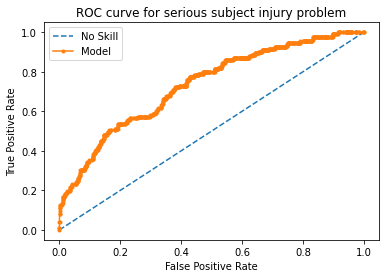

ROC AUC score =  0.7335831782344897


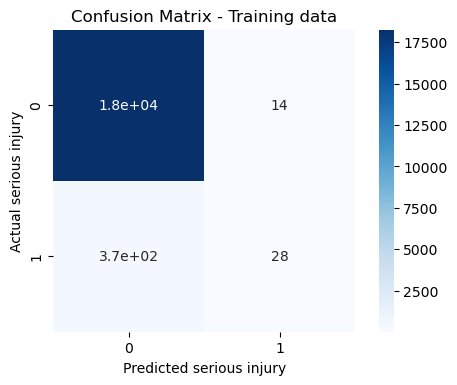

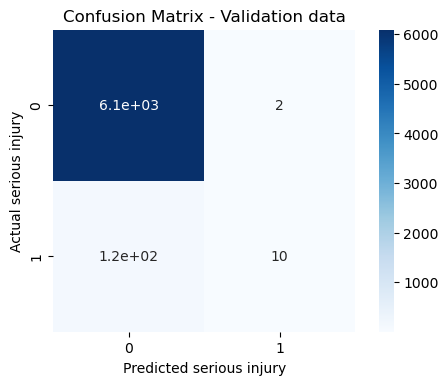

In [24]:
cross_validate_roc_cm(lr_2, X_tr_2,y_tr,X_val_2, y_val)

- LR base model: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR base model: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR base model: mean F2 score from cross-validation: .070


- LR model 2: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 2: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 2: mean F2 score from cross-validation: .085

## LR model 3 

Features:

- subject's age
- whether member suffered an injury
- whether subject used force against member of service
- whether races of subject and member were different
- whether all members suffered an injury
- whether races of subject and all members are different
- force type
- basis for encounter
- patrol borough
- subject's gender
- subject's race
- member's race
- member's gender
- member's title/rank
- member's assignment
- number of subjects involved in incident
- number of members involved in incident

In [25]:
X_tr_3 = X_tr[['subject_age',
       'member_injured_Y','subject_used_force_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER','num_members','num_subjects']]

X_val_3 = X_val[['subject_age',
       'member_injured_Y','subject_used_force_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER', 'num_members','num_subjects']]

In [26]:
lr_3 = LogisticRegression(solver='liblinear',max_iter=10000, random_state=42)
lr_3.fit(X_tr_3, y_tr)

LogisticRegression(max_iter=10000, random_state=42, solver='liblinear')

recall scores: [0.09210526 0.06741573 0.05797101 0.02531646 0.09195402]

mean recall: 0.067

f2 scores: [0.11254019 0.08264463 0.06993007 0.03125    0.11111111]

mean f2 score: 0.081


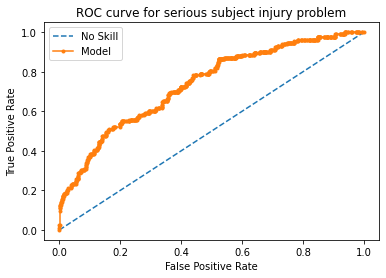

ROC AUC score =  0.7370691995912302


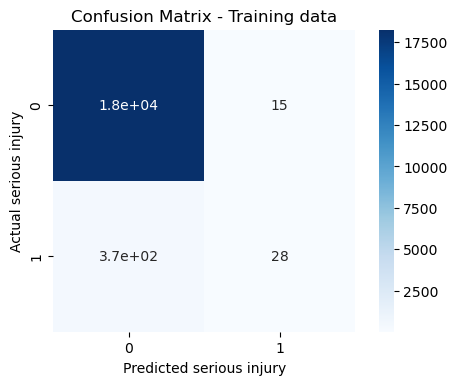

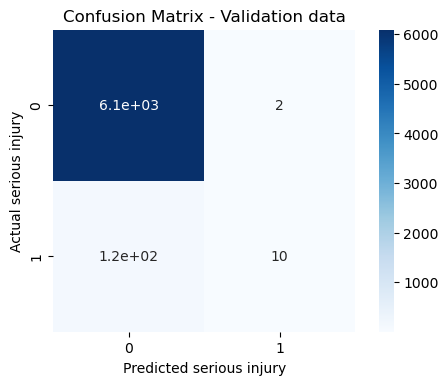

In [27]:
cross_validate_roc_cm(lr_3, X_tr_3,y_tr,X_val_3, y_val)

- LR base model: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR base model: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR base model: mean F2 score from cross-validation: .070


- LR model 2: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 2: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 2: mean F2 score from cross-validation: .085


- LR model 3: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 3: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 3: mean F2 score from cross-validation: .081

## LR model 4 (same features as model 3)

- balanced class weights

In [28]:
lr_4 = LogisticRegression(class_weight = 'balanced', solver='liblinear',max_iter=10000)
lr_4.fit(X_tr_3, y_tr)

LogisticRegression(class_weight='balanced', max_iter=10000, solver='liblinear')

recall scores: [0.56578947 0.64044944 0.52173913 0.6835443  0.63218391]

mean recall: 0.609

f2 scores: [0.15820456 0.18590998 0.13605442 0.18711019 0.19097222]

mean f2 score: 0.172


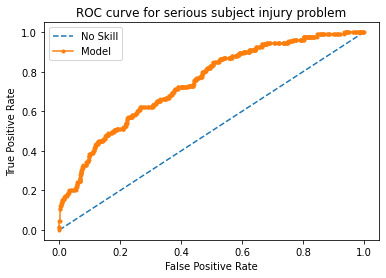

ROC AUC score =  0.7444732152113704


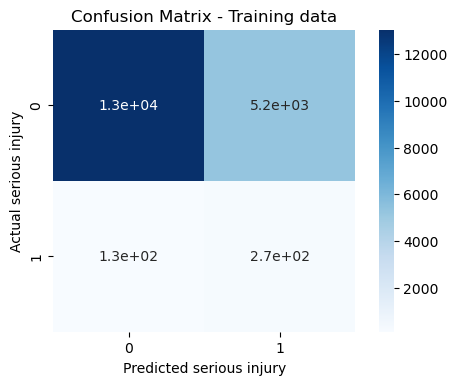

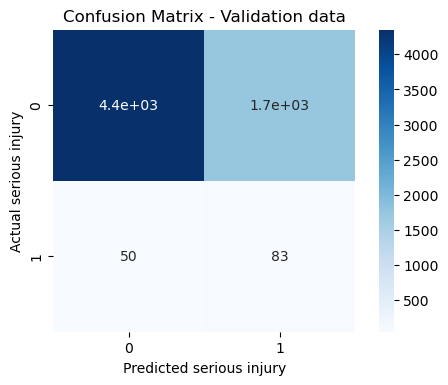

In [29]:
cross_validate_roc_cm(lr_4, X_tr_3, y_tr,X_val_3, y_val)

- LR base model: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR base model: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR base model: mean F2 score from cross-validation: .070


- LR model 2: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 2: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 2: mean F2 score from cross-validation: .085


- LR model 3: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 3: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 3: mean F2 score from cross-validation: .081


- LR model 4: Precision rate with validation data: 83/(83+1700) = 83/1783 = .047
- LR model 4: Recall rate with validation data: 83/(83+50) = 83/133 = .624
- LR model 4: mean F2 score from cross-validation: .171

## LR model 5 (same features as model 3)

- random over sampling

/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (18400) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (18800) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (19200) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning:

Logistic Regression Model best F2 score 0.224 at ratio = 27 to 1


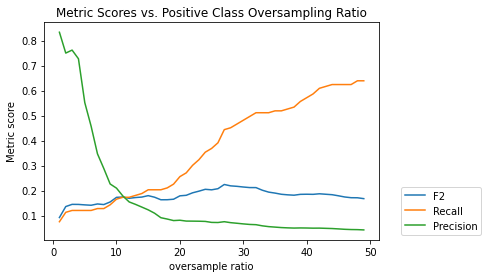

In [30]:
# loop through possible ratios for over-sampling to pick best one to address 
    # class imbalance issue

ratio_ps = range(1,50)

f2_scores, rec_scores, prec_scores = [], [], []

for curr_ratio in ratio_ps:

    n_pos = np.sum(y_tr == 1)
    n_neg = np.sum(y_tr == 0)
    ratio = {1 : n_pos * int(curr_ratio), 0 : n_neg} 

    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_tr_3_os, y_tr_os = ROS.fit_resample(X_tr_3, y_tr)
    
    lr = LogisticRegression(solver='liblinear',max_iter=10000)
    lr.fit(X_tr_3_os,y_tr_os)
    
    f2_scores.append(fbeta_score(y_val, lr.predict(X_val_3), beta=2))    
    rec_scores.append(recall_score(y_val, lr.predict(X_val_3)))
    prec_scores.append(precision_score(y_val, lr.predict(X_val_3)))
    
plt.plot(ratio_ps, f2_scores)
plt.plot(ratio_ps, rec_scores)
plt.plot(ratio_ps, prec_scores)

plt.title('Metric Scores vs. Positive Class Oversampling Ratio')
plt.legend(['F2','Recall','Precision'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('oversample ratio')
plt.ylabel('Metric score')

best_f2_score = np.max(f2_scores) 
best_ratio = ratio_ps[np.argmax(f2_scores)]

print('Logistic Regression Model best F2 score %.3f at ratio = %.0f to 1' 
      % (best_f2_score, best_ratio))

In [31]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 27, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_tr_3_os, y_tr_os = ROS.fit_resample(X_tr_3, y_tr)

In [32]:
lr_5 = LogisticRegression(solver='liblinear',max_iter=10000)
lr_5.fit(X_tr_3_os,y_tr_os)

LogisticRegression(max_iter=10000, solver='liblinear')

recall scores: [0.42525534 0.43729295 0.4487061  0.45351044 0.43387881]

mean recall: 0.440

f2 scores: [0.45855026 0.47094801 0.48112179 0.48681128 0.46969262]

mean f2 score: 0.473


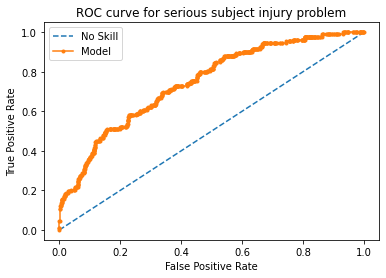

ROC AUC score =  0.7464442458740416


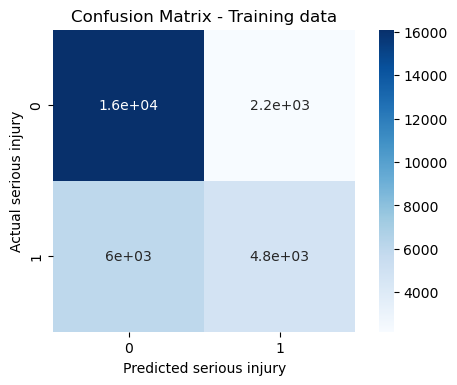

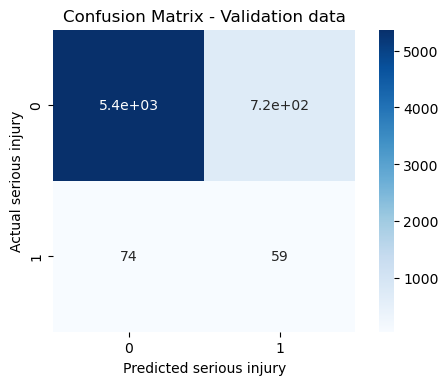

In [33]:
cross_validate_roc_cm(lr_5,X_tr_3_os,y_tr_os,X_val_3,y_val)

- LR base model: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR base model: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR base model: mean F2 score from cross-validation: .070


- LR model 2: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 2: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 2: mean F2 score from cross-validation: .085


- LR model 3: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 3: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 3: mean F2 score from cross-validation: .081


- LR model 4: Precision rate with validation data: 83/(83+1700) = 83/1783 = .047
- LR model 4: Recall rate with validation data: 83/(83+50) = 83/133 = .624
- LR model 4: mean F2 score from cross-validation: .171
        
        
- LR model 5: Precision rate with validation data: 59/(59+720) = 59/779 = .076
- LR model 5: Recall rate with validation data: 59/(59+74) = 59/133 = .451
- LR model 5: mean F2 score from cross-validation: .473

## LR model 6 (same features as model 3)

- SMOTE (synthetic minority oversampling technique)

In [34]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 27, 0 : n_neg} 

In [35]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_tr_3_smote, y_tr_smote = smote.fit_resample(X_tr_3, y_tr)

In [36]:
lr_6 = LogisticRegression(solver='liblinear',random_state = 42) 
lr_6.fit(X_tr_3_smote, y_tr_smote)

LogisticRegression(random_state=42, solver='liblinear')

recall scores: [0.74605385 0.74491245 0.72781885 0.73956357 0.73816895]

mean recall: 0.739

f2 scores: [0.75880631 0.7540481  0.74362606 0.75110811 0.75234403]

mean f2 score: 0.752


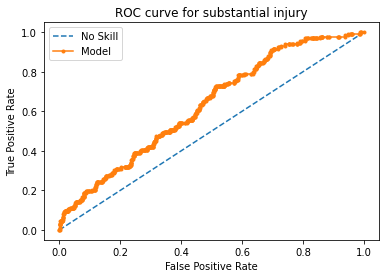

ROC AUC score =  0.6305385097675246


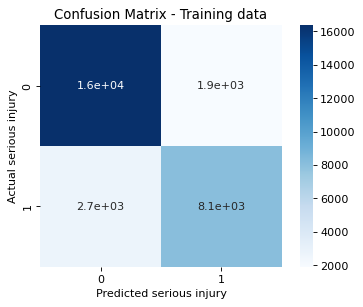

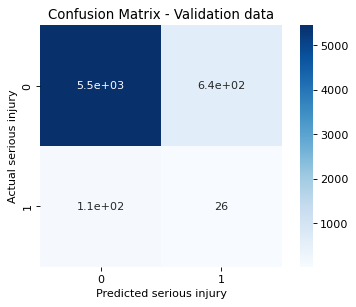

In [142]:
cross_validate_roc_cm(lr_6,X_tr_3_smote,y_tr_smote,X_val_3,y_val)

- LR base model: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR base model: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR base model: mean F2 score from cross-validation: .070


- LR model 2: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 2: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 2: mean F2 score from cross-validation: .085


- LR model 3: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- LR model 3: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- LR model 3: mean F2 score from cross-validation: .081


- LR model 4: Precision rate with validation data: 83/(83+1700) = 83/1783 = .047
- LR model 4: Recall rate with validation data: 83/(83+50) = 83/133 = .624
- LR model 4: mean F2 score from cross-validation: .171
        
        
- LR model 5: Precision rate with validation data: 59/(59+720) = 59/779 = .076
- LR model 5: Recall rate with validation data: 59/(59+74) = 59/133 = .451
- LR model 5: mean F2 score from cross-validation: .473
        
        
- LR model 6: Precision rate with validation data: 26/(26/640) = 26/666 = .039
- LR model 6: Recall rate with validation data: 26/(26+110) = 26/136 = .191
- LR model 6: mean F2 score from cross-validation: .752

## LR model 7 (same features as model 3)

- optimal class_weights and value of C from gridsearch (NOTE: I interrupted the below cell when I re-ran the notebook, but the results from it can be found two cells below, in the cell where the logistic regression class is instantiated and the model is fit).

In [35]:
# I got help with writing this code from this webpage: https://developpaper.com/using-class-weight-to-improve-class-imbalance/

lr_weight_c = LogisticRegression(solver='liblinear')

#Define scoring metrics
f2_score = make_scorer(fbeta_score, beta=2)

#Set the range of class weights
weights = np.linspace(0.0,0.99,200)

#Set the range of C values
c_values = np.linspace(.10,10,100)

#Create dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights], 'C': c_values}

##Fitting training data with grid search method
gridsearch_weight_c = GridSearchCV(estimator= lr_weight_c, 
                          param_grid= param_grid,
                          n_jobs=-1, 
                          scoring=f2_score, 
                          refit=False).fit(X_tr_3, y_tr)

KeyboardInterrupt: 

In [174]:
best_c = gridsearch_weight_c.best_params_['C']
best_class_weight = gridsearch_weight_c.best_params_['class_weight']

In [148]:
lr_7 = LogisticRegression(C=0.9,class_weight={0: 0.03979899497487437, 1: 0.9602010050251256},solver='liblinear',max_iter=10000)
lr_7.fit(X_tr_3,y_tr)

LogisticRegression(C=0.9,
                   class_weight={0: 0.03979899497487437, 1: 0.9602010050251256},
                   max_iter=10000, solver='liblinear')

recall scores: [0.28947368 0.3258427  0.27536232 0.32911392 0.33333333]

mean recall: 0.311

f2 scores: [0.16058394 0.20480226 0.1496063  0.20344288 0.21545319]

mean f2 score: 0.187


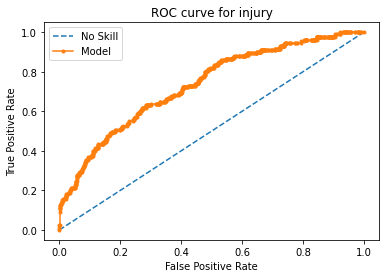

ROC AUC score =  0.7344267596107801


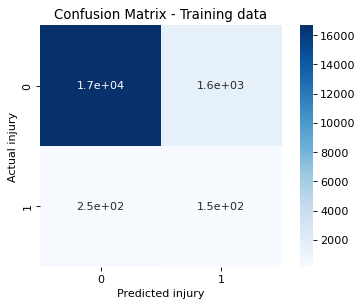

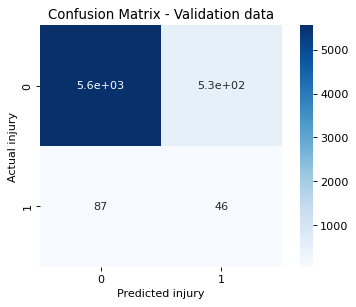

In [149]:
cross_validate_roc_cm(lr_7,X_tr_3,y_tr,X_val_3,y_val)

- Base model: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- Base model: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- Base model: mean F2 score from cross-validation: .070


- Model 2: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- Model 2: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- Model 2: mean F2 score from cross-validation: .085


- Model 3: Precision rate with validation data: 10/(10+2) = 10/12 = .8333
- Model 3: Recall rate with validation data: 10/(10+120) = 10/130 = .077
- Model 3: mean F2 score from cross-validation: .081


- Model 4: Precision rate with validation data: 83/(83+1700) = 83/1783 = .047
- Model 4: Recall rate with validation data: 83/(83+50) = 83/133 = .624
- Model 4: mean F2 score from cross-validation: .171
        
        
- Model 5: Precision rate with validation data: 59/(59+720) = 59/779 = .076
- Model 5: Recall rate with validation data: 59/(59+74) = 59/133 = .451
- Model 5: mean F2 score from cross-validation: .473
        
        
- Model 6: Precision rate with validation data: 26/(26/640) = 26/666 = .039
- Model 6: Recall rate with validation data: 26/(26+110) = 26/136 = .191
- Model 6: mean F2 score from cross-validation: .752
        
        
- Model 7: Precision rate with validation data: 46/(46+530) = 46/576 = .080
- Model 7: Recall rate with validation data: 46/(46+87) = 46/133 = .346
- Model 7: mean F2 score from cross-validation: .184

## Base Random Forest model (same features as lr model 3)

In [38]:
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_tr_3, y_tr)

RandomForestClassifier(random_state=42)

recall scores: [0.22368421 0.23595506 0.2173913  0.21518987 0.2183908 ]

mean recall: 0.222

f2 scores: [0.25993884 0.27559055 0.25167785 0.25373134 0.25333333]

mean f2 score: 0.259


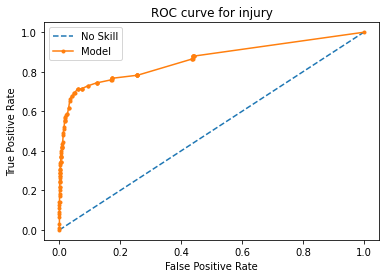

ROC AUC score =  0.8604906471694667


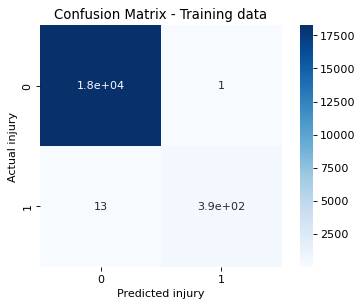

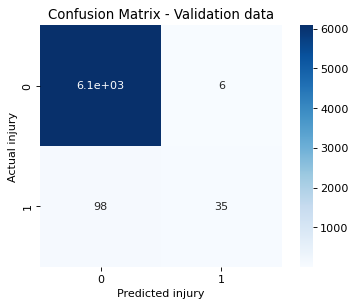

In [146]:
cross_validate_roc_cm(rf_base, X_tr_3,y_tr, X_val_3,y_val)

- RF Base model: Precision rate with validation data: 35/(35+6) = 36/41 = .854
- RF Base model: Recall rate with validation data: 35/(35+98) = 35/133 = .263
- RF Base model: mean F2 score from cross-validation: .259

## Random Forest Model 2 (same features as lr model 3)

- balanced class weights

In [40]:
rf_2 = RandomForestClassifier(class_weight = 'balanced',random_state=42)
rf_2.fit(X_tr_3,y_tr)

RandomForestClassifier(class_weight='balanced', random_state=42)

recall scores: [0.18421053 0.16853933 0.2173913  0.16455696 0.2183908 ]

mean recall: 0.191

f2 scores: [0.21538462 0.20107239 0.25       0.1951952  0.2540107 ]

mean f2 score: 0.223


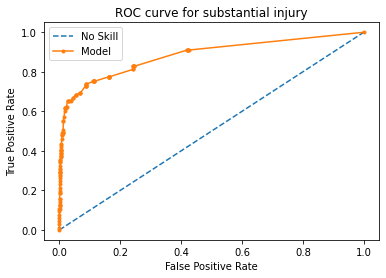

ROC AUC score =  0.8831790984355177


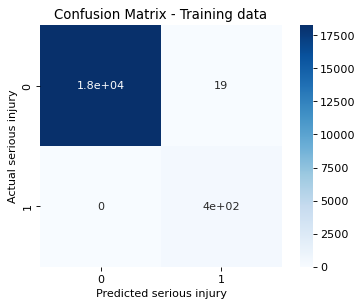

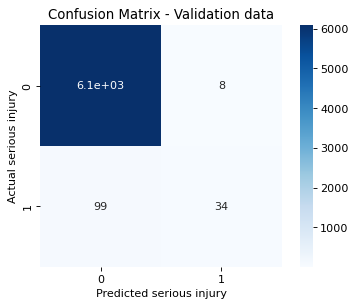

In [144]:
cross_validate_roc_cm(rf_2,X_tr_3,y_tr,X_val_3,y_val)

- RF Base model: Precision rate with validation data: 35/(35+6) = 36/41 = .854
- RF Base model: Recall rate with validation data: 35/(35+98) = 35/133 = .263
- RF Base model: mean F2 score from cross-validation: .259
        
        
- RF Model 2: Precision rate with validation data: 34/(34+8) = 34/42 = .810
- RF Model 2: Recall rate with validation data: 34/(34+99) = 34/133 = .256
- RF Model 2: mean F2 score from cross-validation: .223

## Random Forest Model 3 (same features as lr model 3)

- random over sampling

/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (18400) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (18800) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (19200) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning:

Random Forest Model best F2 score 0.388 at ratio = 47 to 1


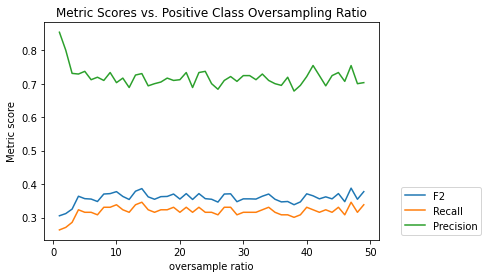

In [43]:
# loop through possible ratios for over-sampling to pick best one to address 
    # class imbalance issue
    
ratio_ps = range(1,50)

f2_scores, rec_scores, prec_scores = [], [], []

for curr_ratio in ratio_ps:

    n_pos = np.sum(y_tr == 1)
    n_neg = np.sum(y_tr == 0)
    ratio = {1 : n_pos * int(curr_ratio), 0 : n_neg} 

    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_tr_3_os_rf, y_tr_os_rf = ROS.fit_resample(X_tr_3, y_tr)
    
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_tr_3_os_rf,y_tr_os_rf)
    
    f2_scores.append(fbeta_score(y_val, rf.predict(X_val_3), beta=2))    
    rec_scores.append(recall_score(y_val, rf.predict(X_val_3)))
    prec_scores.append(precision_score(y_val, rf.predict(X_val_3)))
    
plt.plot(ratio_ps, f2_scores)
plt.plot(ratio_ps, rec_scores)
plt.plot(ratio_ps, prec_scores)

plt.title('Metric Scores vs. Positive Class Oversampling Ratio')
plt.legend(['F2','Recall','Precision'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('oversample ratio')
plt.ylabel('Metric score')

best_f2_score = np.max(f2_scores) 
best_ratio = ratio_ps[np.argmax(f2_scores)]

print('Random Forest Model best F2 score %.3f at ratio = %.0f to 1' 
      % (best_f2_score, best_ratio))

NOTE: Despite the plot above saying 47 to 1 is the optimal over sampling ratio, I'm choosing 14 to 1 in the cell below because the F2 score is nearly the same and this will prevent class 1 from being larger than the number of samples in class 0 (the majority class).

In [43]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 14, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_tr_3_os_rf, y_tr_os_rf = ROS.fit_resample(X_tr_3, y_tr)

In [44]:
rf_3 = RandomForestClassifier(random_state=42)
rf_3.fit(X_tr_3_os_rf,y_tr_os_rf)

RandomForestClassifier(random_state=42)

recall scores: [1. 1. 1. 1. 1.]

mean recall: 1.000

f2 scores: [0.99823944 0.99743308 0.99653221 0.99670511 0.9965035 ]

mean f2 score: 0.997


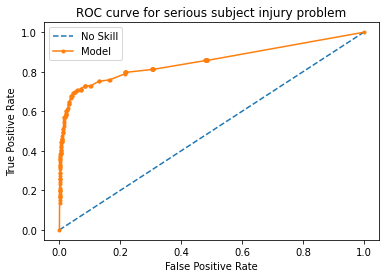

ROC AUC score =  0.8528120202015215


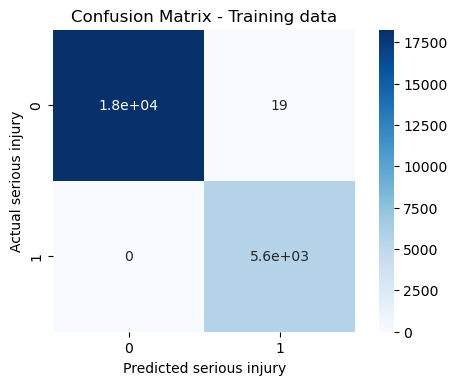

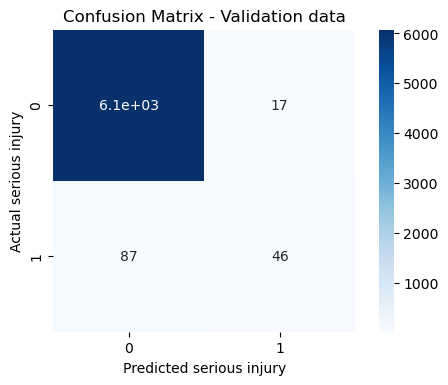

In [45]:
cross_validate_roc_cm(rf_3,X_tr_3_os_rf,y_tr_os_rf,X_val_3,y_val)

- RF Base model: Precision rate with validation data: 35/(35+6) = 36/41 = .854
- RF Base model: Recall rate with validation data: 35/(35+98) = 35/133 = .263
- RF Base model: mean F2 score from cross-validation: .259
        
        
- RF Model 2: Precision rate with validation data: 34/(34+8) = 34/42 = .810
- RF Model 2: Recall rate with validation data: 34/(34+99) = 34/133 = .256
- RF Model 2: mean F2 score from cross-validation: .223


- RF Model 3: Precision rate with validation data: 46/(46+17) = .730
- RF Model 3: Recall rate with validation data: 46/(46+87) = .346
- RF Model 3: mean F2 score from cross-validation: .997

## Random Forest Model 4 (same features as lr model 3)

- smote

In [50]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 14, 0 : n_neg} 

smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_tr_3_smote_rf, y_tr_smote_rf = smote.fit_resample(X_tr_3, y_tr)

In [51]:
rf_4 = RandomForestClassifier(random_state=42)
rf_4.fit(X_tr_3_smote_rf,y_tr_smote_rf)

RandomForestClassifier(random_state=42)

recall scores: [0.94620811 0.94577206 0.93315018 0.92837466 0.9197995 ]

mean recall: 0.935

f2 scores: [0.95293073 0.95260137 0.93951687 0.93645795 0.92942765]

mean f2 score: 0.942


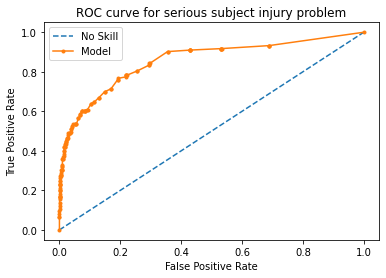

ROC AUC score =  0.8554939548477233


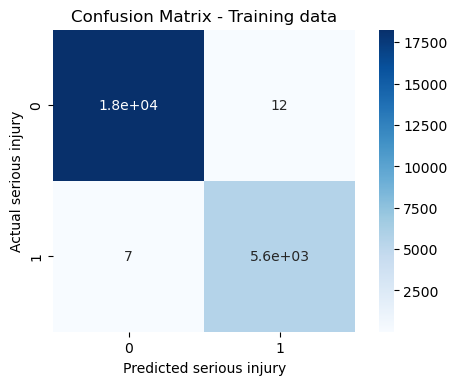

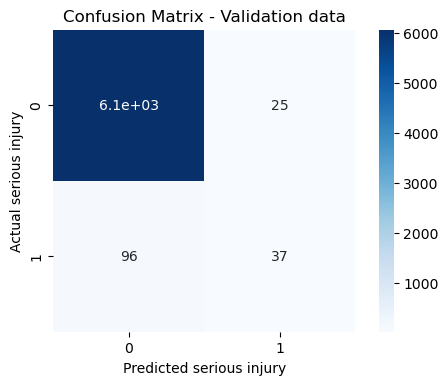

In [52]:
cross_validate_roc_cm(rf_4,X_tr_3_smote_rf,y_tr_smote_rf,X_val_3,y_val)

- RF Base model: Precision rate with validation data: 35/(35+6) = 36/41 = .854
- RF Base model: Recall rate with validation data: 35/(35+98) = 35/133 = .263
- RF Base model: mean F2 score from cross-validation: .259
        
        
- RF Model 2: Precision rate with validation data: 34/(34+8) = 34/42 = .810
- RF Model 2: Recall rate with validation data: 34/(34+99) = 34/133 = .256
- RF Model 2: mean F2 score from cross-validation: .223


- RF Model 3: Precision rate with validation data: 46/(46+17) = .730
- RF Model 3: Recall rate with validation data: 46/(46+87) = .346
- RF Model 3: mean F2 score from cross-validation: .997
        

- RF Model 4: Precision rate with validation data: 37/(37+25) = .597
- RF Model 4: Recall rate with validation data: 37/(37+96) = .278
- RF Model 4: mean F2 score from cross-validation: .942

## Random Forest Model 5 (same features as lr model 3)

- balanced sub-sample class weights

recall scores: [0.18421053 0.19101124 0.24637681 0.17721519 0.1954023 ]

mean recall: 0.199

f2 scores: [0.21538462 0.22666667 0.28239203 0.20895522 0.22972973]

mean f2 score: 0.233


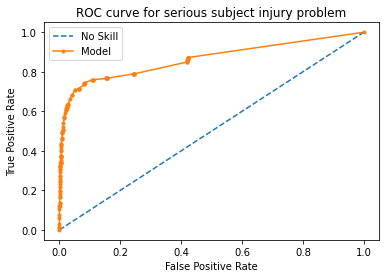

ROC AUC score =  0.8635521008693764


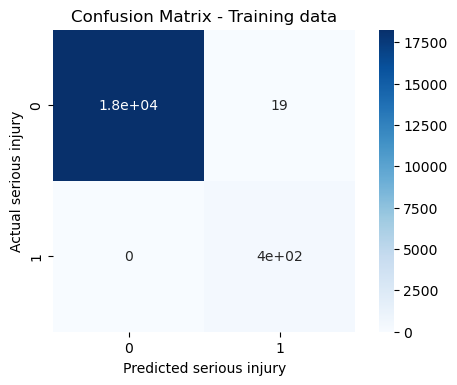

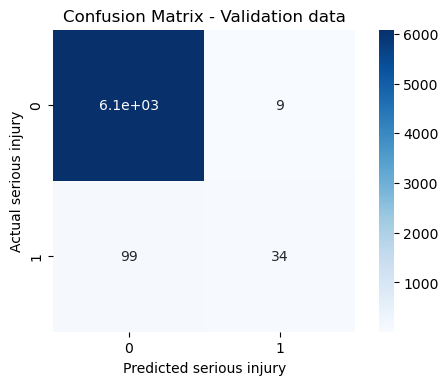

In [53]:
rf_5 = RandomForestClassifier(class_weight = 'balanced_subsample',random_state=42)
rf_5.fit(X_tr_3,y_tr)

cross_validate_roc_cm(rf_5,X_tr_3,y_tr,X_val_3,y_val)

- RF Base model: Precision rate with validation data: 35/(35+6) = 36/41 = .854
- RF Base model: Recall rate with validation data: 35/(35+98) = 35/133 = .263
- RF Base model: mean F2 score from cross-validation: .259
        
        
- RF Model 2: Precision rate with validation data: 34/(34+8) = 34/42 = .810
- RF Model 2: Recall rate with validation data: 34/(34+99) = 34/133 = .256
- RF Model 2: mean F2 score from cross-validation: .223


- RF Model 3: Precision rate with validation data: 46/(46+17) = .730
- RF Model 3: Recall rate with validation data: 46/(46+87) = .346
- RF Model 3: mean F2 score from cross-validation: .997
        

- RF Model 4: Precision rate with validation data: 37/(37+25) = .597
- RF Model 4: Recall rate with validation data: 37/(37+96) = .278
- RF Model 4: mean F2 score from cross-validation: .942
        
        
- RF Model 5: Precision rate with validation data: 34/(34+9) = .791
- RF Model 5: Recall rate with validation data: 34/(34+99) = .256
- RF Model 5: mean F2 score from cross-validation: .233

## Feature selection using randomly oversampled data and features from LR model 3

In [54]:
sel = SelectFromModel(RandomForestClassifier(random_state=42))
sel.fit(X_tr_3_os_rf,y_tr_os_rf)

SelectFromModel(estimator=RandomForestClassifier(random_state=42))

In [55]:
sel.get_support()

array([ True,  True, False, False,  True,  True,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False,  True,  True, False,  True,
       False, False, False, False, False,  True,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True])

In [56]:
selected_feat= X_tr_3.columns[(sel.get_support())]
len(selected_feat)

18

In [57]:
print(selected_feat)

Index(['subject_age', 'member_injured_Y', 'member_injured_all_Y',
       'race_diff_all_Y', 'forcetype_Electrical Weapon', 'forcetype_Firearm',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_PERSON IN CRISIS', 'patrol_borough_PBBN',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBQN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'member_race_HISPANIC',
       'member_assignment_OTHER', 'num_members', 'num_subjects'],
      dtype='object')


## Random Forest Model 6 (selected features)

- random over-sampling and selected features

In [58]:
X_tr_3_sel = X_tr_3[['subject_age', 'member_injured_all_Y',
       'race_diff_all_Y', 'forcetype_Electrical Weapon', 'forcetype_Firearm',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_PERSON IN CRISIS', 'patrol_borough_PBBN',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBQN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'member_race_HISPANIC',
       'member_assignment_OTHER', 'num_members', 'num_subjects']]

X_val_3_sel = X_val_3[['subject_age', 'member_injured_all_Y',
       'race_diff_all_Y', 'forcetype_Electrical Weapon', 'forcetype_Firearm',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_PERSON IN CRISIS', 'patrol_borough_PBBN',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBQN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'member_race_HISPANIC',
       'member_assignment_OTHER', 'num_members', 'num_subjects']]

/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (18400) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (18800) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (19200) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18275)
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/imblearn/utils/_validation.py:299: UserWarning:

Random Forest Model best F2 score 0.528 at ratio = 7 to 1


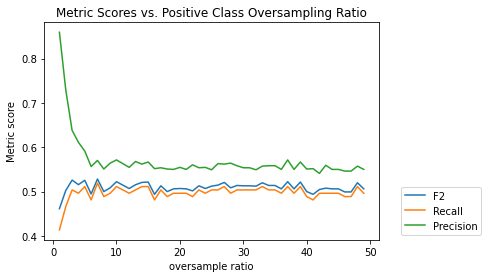

In [150]:
# loop through possible ratios for over-sampling to pick best one to address 
    # class imbalance issue
    
ratio_ps = range(1,50)

f2_scores, rec_scores, prec_scores = [], [], []

for curr_ratio in ratio_ps:

    n_pos = np.sum(y_tr == 1)
    n_neg = np.sum(y_tr == 0)
    ratio = {1 : n_pos * int(curr_ratio), 0 : n_neg} 

    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_tr_3_os_rf_sel, y_tr_os_rf_sel = ROS.fit_resample(X_tr_3_sel, y_tr)
    
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_tr_3_os_rf_sel,y_tr_os_rf_sel)
    
    f2_scores.append(fbeta_score(y_val, rf.predict(X_val_3_sel), beta=2))    
    rec_scores.append(recall_score(y_val, rf.predict(X_val_3_sel)))
    prec_scores.append(precision_score(y_val, rf.predict(X_val_3_sel)))
    
plt.plot(ratio_ps, f2_scores)
plt.plot(ratio_ps, rec_scores)
plt.plot(ratio_ps, prec_scores)

plt.title('Metric Scores vs. Positive Class Oversampling Ratio')
plt.legend(['F2','Recall','Precision'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('oversample ratio')
plt.ylabel('Metric score')

best_f2_score = np.max(f2_scores) 
best_ratio = ratio_ps[np.argmax(f2_scores)]

print('Random Forest Model best F2 score %.3f at ratio = %.0f to 1' 
      % (best_f2_score, best_ratio))

In [60]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 7, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_tr_3_os_rf_sel, y_tr_os_rf_sel = ROS.fit_resample(X_tr_3_sel, y_tr)

recall scores: [0.99440299 1.         0.98934281 0.99084249 0.99509002]

mean recall: 0.994

f2 scores: [0.9866716  0.98443721 0.97959902 0.97759306 0.98605255]

mean f2 score: 0.983


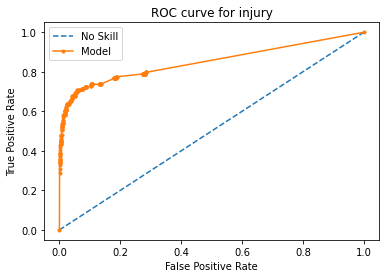

ROC AUC score =  0.8494235013008555


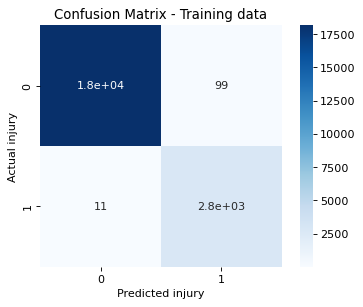

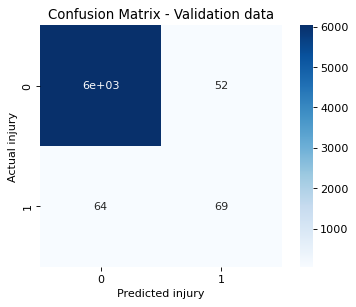

In [147]:
rf_6 = RandomForestClassifier(random_state=42)
rf_6.fit(X_tr_3_os_rf_sel,y_tr_os_rf_sel)

cross_validate_roc_cm(rf_6,X_tr_3_os_rf_sel,y_tr_os_rf_sel,X_val_3_sel,y_val)

- RF Base model: Precision rate with validation data: 35/(35+6) = 36/41 = .854
- RF Base model: Recall rate with validation data: 35/(35+98) = 35/133 = .263
- RF Base model: mean F2 score from cross-validation: .259
        
        
- RF Model 2: Precision rate with validation data: 34/(34+8) = 34/42 = .810
- RF Model 2: Recall rate with validation data: 34/(34+99) = 34/133 = .256
- RF Model 2: mean F2 score from cross-validation: .223


- RF Model 3: Precision rate with validation data: 46/(46+17) = .730
- RF Model 3: Recall rate with validation data: 46/(46+87) = .346
- RF Model 3: mean F2 score from cross-validation: .997
        

- RF Model 4: Precision rate with validation data: 37/(37+25) = .597
- RF Model 4: Recall rate with validation data: 37/(37+96) = .278
- RF Model 4: mean F2 score from cross-validation: .942
        
        
- RF Model 5: Precision rate with validation data: 34/(34+9) = .791
- RF Model 5: Recall rate with validation data: 34/(34+99) = .256
- RF Model 5: mean F2 score from cross-validation: .233
        
        
- RF Model 6: Precision rate with validation data: 69/(69+52) = .570
- RF Model 6: Recall rate with validation data: 69/(69+64) = .519
- RF Model 6: mean F2 score from cross-validation: .983

Since Random Forest Model 6 is the best performing model based on cross-validation and the ROC-AUC score, I will evaluate it with the holdout test set.

In [80]:
X_te_3 = X_te[['subject_age',
       'member_injured_Y','subject_used_force_Y','race_diff_Y',
               'member_injured_all_Y','race_diff_all_Y','forcetype_Electrical Weapon',
       'forcetype_Firearm','forcetype_Impact Weapon','forcetype_OC Spray',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
       'patrol_borough_PBBN', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'subject_gender_FEMALE', 'subject_gender_MALE',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'member_race_AMER INDIAN','member_race_ASIAN', 'member_race_BLACK', 
       'member_race_HISPANIC',
       'member_race_UNK/OTH', 'member_gender_FEMALE', 'member_rank_Captain',
       'member_rank_Chief', 'member_rank_Deputy Inspector',
       'member_rank_Detective', 'member_rank_Inspector',
       'member_rank_Lieutenant', 'member_rank_Other', 'member_rank_RECODE',
       'member_rank_Sergeant', 'member_assignment_ANTI-CRIME',
       'member_assignment_FIXED POST', 'member_assignment_INVESTIGATION',
       'member_assignment_NCO', 'member_assignment_OFF DUTY',
       'member_assignment_OTHER', 'member_assignment_SCOOTER', 'num_members','num_subjects']]

X_te_3_sel = X_te_3[['subject_age','member_injured_all_Y',
       'race_diff_all_Y', 'forcetype_Electrical Weapon', 'forcetype_Firearm',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_PERSON IN CRISIS', 'patrol_borough_PBBN',
       'patrol_borough_PBBX', 'patrol_borough_PBMN', 'patrol_borough_PBQN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'member_race_HISPANIC',
       'member_assignment_OTHER', 'num_members', 'num_subjects']]

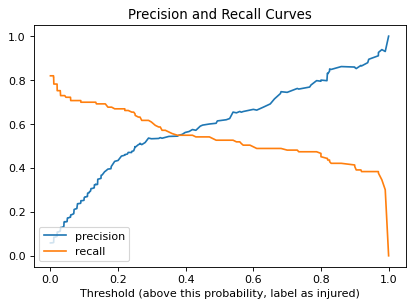

In [422]:
#plotting a precision/recall curve for different probability thresholds with the predictions

precision_curve,recall_curve,threshold_curve = precision_recall_curve(y_te,rf_6.predict_proba(X_te_3_sel)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as injured)');
plt.title('Precision and Recall Curves');

In [81]:
# calculate predicted probabilities of positive class with holdout set and adjust
    # the probability threshold to maximize recall without sacrificing 
    # the precision score too much

y_predict_rf_6 = (rf_6.predict_proba(X_te_3_sel)[:,1]>.25)
print("Precision:{:6.4f},Recall:{:6.4f},F2:{:6.4f}".format(precision_score(y_te, np.round(y_predict_rf_6)), 
                                                     recall_score(y_te, np.round(y_predict_rf_6)),
                                                     fbeta_score(y_te, np.round(y_predict_rf_6), beta=2)))

Precision:0.4943,Recall:0.6466,F2:0.6091


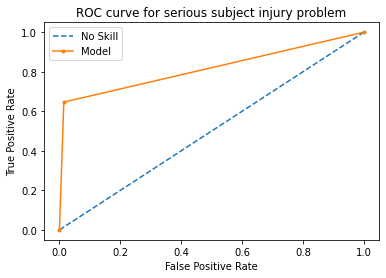

0.8160868690682886

In [62]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_te, (rf_6.predict_proba(X_te_3_sel)[:,1]>.25)) 

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Model')

# axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for serious subject injury problem')
plt.legend()
plt.show()
roc_auc_score(y_te, (rf_6.predict_proba(X_te_3_sel)[:,1]>.25))

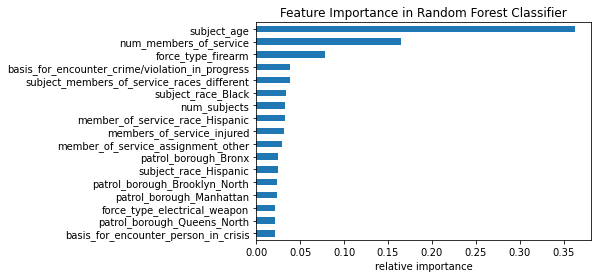

In [126]:
# plot the final 17 features in descending order of relative importance

importances = rf_6.feature_importances_

sorted_indices = np.argsort(importances)[::-1]

X_te_3_sel.columns = ['subject_age','members_of_service_injured',
                               'subject_members_of_service_races_different',
                               'force_type_electrical_weapon','force_type_firearm',
                               'basis_for_encounter_crime/violation_in_progress',
                               'basis_for_encounter_person_in_crisis',
                               'patrol_borough_Brooklyn_North','patrol_borough_Bronx',
                               'patrol_borough_Manhattan','patrol_borough_Queens_North',
                               'subject_race_Black','subject_race_Hispanic',
                                'member_of_service_race_Hispanic',
                                'member_of_service_assignment_other','num_members_of_service',
                               'num_subjects']

feature_importances = pd.Series(rf_6.feature_importances_, index=X_te_3_sel.columns)
ax = feature_importances.nlargest(17).plot(kind='barh')
ax.invert_yaxis()
ax.set_xlabel('relative importance')
ax.set_title('Feature Importance in Random Forest Classifier')
plt.savefig('feature_importance_rf.png',bbox_inches='tight')

In [129]:
# create a new column that calculates the percent of trees in the random forest that voted
    # towards the positive class

X_te_3_sel['predicted_prob'] = rf_6.predict_proba(X_te_3_sel)[:,1]

/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- basis_for_encounter_crime/violation_in_progress
- basis_for_encounter_person_in_crisis
- force_type_electrical_weapon
- force_type_firearm
- member_of_service_assignment_other
- ...
Feature names seen at fit time, yet now missing:
- basis_encounter_CRIME/VIOLATION IN PROGRESS
- basis_encounter_PERSON IN CRISIS
- forcetype_Electrical Weapon
- forcetype_Firearm
- member_assignment_OTHER
- ...

  warnings.warn(message, FutureWarning)
/var/folders/39/jt9qcrmn79dgs0dxlm65sdn40000gn/T/ipykernel_70269/2517461493.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

Analyze force type average predicted probabilities

In [72]:
# firearm

X_te_3_sel.groupby('force_type_firearm').mean('predicted_prob')#~71% avg prob injury

,subject_age,members_of_service_injured,subject_members_of_service_races_different,force_type_electrical_weapon,basis_for_encounter_crime/violation_in_progress,basis_for_encounter_person_in_crisis,patrol_borough_Brooklyn_North,patrol_borough_Bronx,patrol_borough_Manhattan,patrol_borough_Queens_North,subject_race_Black,subject_race_Hispanic,member_of_service_race_Hispanic,member_of_service_assignment_other,num_members_of_service,num_subjects,predicted_prob
force_type_firearm,,,,,,,,,,,,,,,,,
0,0.007137,0.726892,0.561192,0.08905,0.410789,0.263446,0.143961,0.246538,0.10789,0.087601,0.566345,0.282609,0.322705,0.193559,-0.015728,0.018869,0.028329
1,0.136797,1.000000,0.750000,0.00000,0.375000,0.062500,0.062500,0.187500,0.12500,0.125000,0.437500,0.312500,0.375000,0.187500,-0.357720,-0.095024,0.708750


In [73]:
# electrical weapon

X_te_3_sel.groupby('force_type_electrical_weapon').mean('predicted_prob')#5% avg prob injury

,subject_age,members_of_service_injured,subject_members_of_service_races_different,force_type_firearm,basis_for_encounter_crime/violation_in_progress,basis_for_encounter_person_in_crisis,patrol_borough_Brooklyn_North,patrol_borough_Bronx,patrol_borough_Manhattan,patrol_borough_Queens_North,subject_race_Black,subject_race_Hispanic,member_of_service_race_Hispanic,member_of_service_assignment_other,num_members_of_service,num_subjects,predicted_prob
force_type_electrical_weapon,,,,,,,,,,,,,,,,,
0,-0.008124,0.725542,0.553852,0.00282,0.410541,0.253305,0.144368,0.236735,0.105235,0.091839,0.563899,0.281685,0.320289,0.195664,0.019954,0.031311,0.028442
1,0.167442,0.748644,0.641953,0.00000,0.412297,0.361664,0.137432,0.345389,0.135624,0.045208,0.587703,0.292948,0.349005,0.171790,-0.391676,-0.112065,0.046858


Analyze races different average predicted probability

In [74]:
X_te_3_sel.groupby('subject_members_of_service_races_different').mean('predicted_prob')#~3% avg prob injury

,subject_age,members_of_service_injured,force_type_electrical_weapon,force_type_firearm,basis_for_encounter_crime/violation_in_progress,basis_for_encounter_person_in_crisis,patrol_borough_Brooklyn_North,patrol_borough_Bronx,patrol_borough_Manhattan,patrol_borough_Queens_North,subject_race_Black,subject_race_Hispanic,member_of_service_race_Hispanic,member_of_service_assignment_other,num_members_of_service,num_subjects,predicted_prob
subject_members_of_service_races_different,,,,,,,,,,,,,,,,,
0,0.01917,0.688897,0.072554,0.001466,0.388787,0.282521,0.154269,0.265299,0.114328,0.106632,0.380726,0.426530,0.365702,0.182118,0.258314,0.121557,0.026302
1,-0.00166,0.757792,0.101516,0.003432,0.427795,0.247641,0.135545,0.231627,0.102945,0.072920,0.710609,0.170432,0.289391,0.202459,-0.231151,-0.061788,0.033024


Analyze bases for encounter average predicted probabilities

In [75]:
# crime/violation in progress

X_te_3_sel.groupby('basis_for_encounter_crime/violation_in_progress').mean('predicted_prob')#~4% avg prob injury

,subject_age,members_of_service_injured,subject_members_of_service_races_different,force_type_electrical_weapon,force_type_firearm,basis_for_encounter_person_in_crisis,patrol_borough_Brooklyn_North,patrol_borough_Bronx,patrol_borough_Manhattan,patrol_borough_Queens_North,subject_race_Black,subject_race_Hispanic,member_of_service_race_Hispanic,member_of_service_assignment_other,num_members_of_service,num_subjects,predicted_prob
basis_for_encounter_crime/violation_in_progress,,,,,,,,,,,,,,,,,
0,0.067345,0.724721,0.545380,0.088580,0.002726,0.446171,0.145271,0.242028,0.110384,0.089670,0.558190,0.271191,0.322976,0.198692,-0.013987,-0.081551,0.026136
1,-0.078443,0.731717,0.585061,0.089167,0.002346,0.000000,0.141572,0.252640,0.104419,0.084865,0.577239,0.299179,0.322644,0.186156,-0.020366,0.162247,0.035733


In [76]:
# person in crisis

X_te_3_sel.groupby('basis_for_encounter_person_in_crisis').mean('predicted_prob')#~2% avg prob injury

,subject_age,members_of_service_injured,subject_members_of_service_races_different,force_type_electrical_weapon,force_type_firearm,basis_for_encounter_crime/violation_in_progress,patrol_borough_Brooklyn_North,patrol_borough_Bronx,patrol_borough_Manhattan,patrol_borough_Queens_North,subject_race_Black,subject_race_Hispanic,member_of_service_race_Hispanic,member_of_service_assignment_other,num_members_of_service,num_subjects,predicted_prob
basis_for_encounter_person_in_crisis,,,,,,,,,,,,,,,,,
0,-0.066305,0.732621,0.573328,0.076923,0.003269,0.557202,0.159512,0.245369,0.106559,0.082589,0.585095,0.282197,0.326215,0.228154,-0.050053,0.100207,0.033326
1,0.214285,0.713500,0.529016,0.122175,0.000611,0.000000,0.099572,0.249236,0.111790,0.102016,0.512523,0.284056,0.313378,0.096518,0.077150,-0.210259,0.020970


Analyze subject race black average predicted probability

In [77]:
X_te_3_sel.groupby('subject_race_Black').mean('predicted_prob')#~3% avg prob injury

,subject_age,members_of_service_injured,subject_members_of_service_races_different,force_type_electrical_weapon,force_type_firearm,basis_for_encounter_crime/violation_in_progress,basis_for_encounter_person_in_crisis,patrol_borough_Brooklyn_North,patrol_borough_Bronx,patrol_borough_Manhattan,patrol_borough_Queens_North,subject_race_Hispanic,member_of_service_race_Hispanic,member_of_service_assignment_other,num_members_of_service,num_subjects,predicted_prob
subject_race_Black,,,,,,,,,,,,,,,,,
0,0.052667,0.703923,0.374537,0.084382,0.003331,0.400074,0.295337,0.089933,0.250925,0.11510,0.138416,0.651369,0.327535,0.184308,-0.014785,0.086702,0.028108
1,-0.027184,0.745743,0.705165,0.092225,0.001986,0.418842,0.238082,0.185017,0.242906,0.10244,0.048808,0.000000,0.319240,0.200624,-0.018004,-0.033659,0.031588


Analyze subject age's average predicted probabilities

In [78]:
# inverse transform scaled numeric features
X_te_3_sel[['num_members_of_service','num_subjects','subject_age']] = scaler.inverse_transform(X_te_3_sel[['num_members_of_service','num_subjects','subject_age']])

/var/folders/39/jt9qcrmn79dgs0dxlm65sdn40000gn/T/ipykernel_68919/3673615743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_3_sel[['num_members_of_service','num_subjects','subject_age']] = scaler.inverse_transform(X_te_3_sel[['num_members_of_service','num_subjects','subject_age']])


<AxesSubplot:xlabel='subject_age', ylabel='Count'>

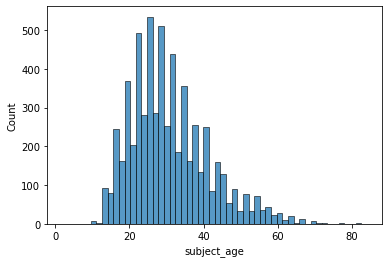

In [79]:
sns.histplot(data=X_te_3_sel, x='subject_age')

In [80]:
X_te_3_sel[['subject_age']].describe()

,subject_age
count,6226.000000
mean,30.752329
std,10.650490
min,2.000000
25%,23.000000
50%,29.000000
75%,37.000000
max,84.000000


In [81]:
def age_bins(x):
    if x < 23:
        return 'under 23'
    elif x >= 23 and x < 29:
        return '23 to 29'
    elif x >= 29 and x < 37:
        return '29 to 37'
    else:
        return '37 and over'

In [82]:
X_te_3_sel['subject_age_bins'] = X_te_3_sel['subject_age'].map(age_bins)

/var/folders/39/jt9qcrmn79dgs0dxlm65sdn40000gn/T/ipykernel_68919/3418142121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_3_sel['subject_age_bins'] = X_te_3_sel['subject_age'].map(age_bins)


In [83]:
X_te_3_sel['subject_age_bins'].value_counts()

29 to 37       1657
23 to 29       1596
37 and over    1562
under 23       1411
Name: subject_age_bins, dtype: int64

In [84]:
X_te_3_sel.groupby('subject_age_bins').mean('predicted_prob')

,subject_age,members_of_service_injured,subject_members_of_service_races_different,force_type_electrical_weapon,force_type_firearm,basis_for_encounter_crime/violation_in_progress,basis_for_encounter_person_in_crisis,patrol_borough_Brooklyn_North,patrol_borough_Bronx,patrol_borough_Manhattan,patrol_borough_Queens_North,subject_race_Black,subject_race_Hispanic,member_of_service_race_Hispanic,member_of_service_assignment_other,num_members_of_service,num_subjects,predicted_prob
subject_age_bins,,,,,,,,,,,,,,,,,,
23 to 29,25.510652,0.688596,0.547619,0.095238,0.003759,0.418546,0.237469,0.134712,0.251253,0.124060,0.092732,0.577068,0.275689,0.329574,0.229950,3.559524,1.176065,0.028853
29 to 37,32.130356,0.729028,0.563669,0.098974,0.000604,0.396500,0.263730,0.159324,0.237176,0.095353,0.092939,0.547978,0.278817,0.322873,0.185275,3.455039,1.135788,0.034179
37 and over,45.485915,0.776569,0.558899,0.101793,0.003841,0.372599,0.341869,0.142766,0.212548,0.124840,0.085787,0.548015,0.273367,0.327785,0.165813,3.228553,1.094750,0.036183
under 23,18.752658,0.715804,0.578313,0.055280,0.002126,0.460666,0.203402,0.136782,0.289157,0.085755,0.077959,0.594614,0.305457,0.309709,0.192771,3.422395,1.467045,0.019886


Analyze members_of_service_injured's average predicted probabilities

In [85]:
X_te_3_sel.groupby('members_of_service_injured').mean('predicted_prob')#3% avg prob injury

,subject_age,subject_members_of_service_races_different,force_type_electrical_weapon,force_type_firearm,basis_for_encounter_crime/violation_in_progress,basis_for_encounter_person_in_crisis,patrol_borough_Brooklyn_North,patrol_borough_Bronx,patrol_borough_Manhattan,patrol_borough_Queens_North,subject_race_Black,subject_race_Hispanic,member_of_service_race_Hispanic,member_of_service_assignment_other,num_members_of_service,num_subjects,predicted_prob
members_of_service_injured,,,,,,,,,,,,,,,,,
0,29.570755,0.499410,0.081958,0.000000,0.404481,0.276533,0.143278,0.242925,0.110259,0.087264,0.528302,0.305425,0.316038,0.185731,4.376179,1.441038,0.038653
1,31.194702,0.584989,0.091391,0.003532,0.413024,0.257837,0.143929,0.247682,0.107064,0.087859,0.580132,0.274172,0.325386,0.196468,3.058720,1.124724,0.026867


Analyze patrol boroughs' average predicted probabilities

In [86]:
X_te_3_sel.columns

Index(['subject_age', 'members_of_service_injured',
       'subject_members_of_service_races_different',
       'force_type_electrical_weapon', 'force_type_firearm',
       'basis_for_encounter_crime/violation_in_progress',
       'basis_for_encounter_person_in_crisis', 'patrol_borough_Brooklyn_North',
       'patrol_borough_Bronx', 'patrol_borough_Manhattan',
       'patrol_borough_Queens_North', 'subject_race_Black',
       'subject_race_Hispanic', 'member_of_service_race_Hispanic',
       'member_of_service_assignment_other', 'num_members_of_service',
       'num_subjects', 'predicted_prob', 'subject_age_bins'],
      dtype='object')

In [87]:
# patrol_borough_Brooklyn_North

X_te_3_sel.groupby('patrol_borough_Brooklyn_North').mean('predicted_prob')#~4% avg prob injury

,subject_age,members_of_service_injured,subject_members_of_service_races_different,force_type_electrical_weapon,force_type_firearm,basis_for_encounter_crime/violation_in_progress,basis_for_encounter_person_in_crisis,patrol_borough_Bronx,patrol_borough_Manhattan,patrol_borough_Queens_North,subject_race_Black,subject_race_Hispanic,member_of_service_race_Hispanic,member_of_service_assignment_other,num_members_of_service,num_subjects,predicted_prob
patrol_borough_Brooklyn_North,,,,,,,,,,,,,,,,,
0,30.697243,0.727443,0.567061,0.089477,0.002814,0.411743,0.276496,0.287751,0.126055,0.10242,0.538736,0.300506,0.328269,0.191521,3.444757,1.209154,0.028341
1,31.080447,0.728492,0.529609,0.084916,0.001117,0.404469,0.182123,0.000000,0.000000,0.00000,0.728492,0.176536,0.290503,0.205587,3.255866,1.221229,0.040423


In [88]:
# patrol_borough_Bronx

X_te_3_sel.groupby('patrol_borough_Bronx').mean('predicted_prob')#~2% avg prob injury

,subject_age,members_of_service_injured,subject_members_of_service_races_different,force_type_electrical_weapon,force_type_firearm,basis_for_encounter_crime/violation_in_progress,basis_for_encounter_person_in_crisis,patrol_borough_Brooklyn_North,patrol_borough_Manhattan,patrol_borough_Queens_North,subject_race_Black,subject_race_Hispanic,member_of_service_race_Hispanic,member_of_service_assignment_other,num_members_of_service,num_subjects,predicted_prob
patrol_borough_Bronx,,,,,,,,,,,,,,,,,
0,31.108483,0.726343,0.572677,0.077153,0.002771,0.407289,0.261935,0.19075,0.143223,0.116368,0.568627,0.251492,0.263640,0.186488,3.452259,1.164535,0.032891
1,29.662973,0.731421,0.528031,0.124511,0.001956,0.421121,0.265971,0.00000,0.000000,0.000000,0.558018,0.378096,0.503911,0.215124,3.311604,1.352673,0.021471


In [89]:
# patrol_borough_Manhattan

X_te_3_sel.groupby('patrol_borough_Manhattan').mean('predicted_prob')#~4% avg prob injury

,subject_age,members_of_service_injured,subject_members_of_service_races_different,force_type_electrical_weapon,force_type_firearm,basis_for_encounter_crime/violation_in_progress,basis_for_encounter_person_in_crisis,patrol_borough_Brooklyn_North,patrol_borough_Bronx,patrol_borough_Queens_North,subject_race_Black,subject_race_Hispanic,member_of_service_race_Hispanic,member_of_service_assignment_other,num_members_of_service,num_subjects,predicted_prob
patrol_borough_Manhattan,,,,,,,,,,,,,,,,,
0,30.625315,0.728304,0.564818,0.086064,0.002521,0.412315,0.261793,0.161145,0.276197,0.098308,0.569499,0.275297,0.313648,0.196255,3.428880,1.221462,0.028378
1,31.802083,0.721726,0.535714,0.111607,0.002976,0.397321,0.272321,0.000000,0.000000,0.000000,0.537202,0.343750,0.398810,0.171131,3.324405,1.123512,0.044127


In [90]:
# patrol_borough_Queens_North

X_te_3_sel.groupby('patrol_borough_Queens_North').mean('predicted_prob')#~4% avg prob injury

,subject_age,members_of_service_injured,subject_members_of_service_races_different,force_type_electrical_weapon,force_type_firearm,basis_for_encounter_crime/violation_in_progress,basis_for_encounter_person_in_crisis,patrol_borough_Brooklyn_North,patrol_borough_Bronx,patrol_borough_Manhattan,subject_race_Black,subject_race_Hispanic,member_of_service_race_Hispanic,member_of_service_assignment_other,num_members_of_service,num_subjects,predicted_prob
patrol_borough_Queens_North,,,,,,,,,,,,,,,,,
0,30.676408,0.727465,0.570775,0.092958,0.002465,0.411972,0.258803,0.15757,0.27007,0.11831,0.590141,0.270775,0.332042,0.194894,3.381514,1.216197,0.029246
1,31.542125,0.728938,0.467033,0.045788,0.003663,0.397436,0.305861,0.00000,0.00000,0.00000,0.315018,0.406593,0.227106,0.179487,3.793040,1.155678,0.038727


Analyze number of members of service

In [91]:
X_te_3_sel[['num_members_of_service']].describe()

,num_members_of_service
count,6226.000000
mean,3.417604
std,1.926615
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,14.000000


In [92]:
def num_members_bins(x):
    if x <= 2:
        return '1 to 2'
    elif x == 3:
        return '3'
    elif x == 4:
        return '4'
    else:
        return 'over 4'

In [94]:
X_te_3_sel['num_members_of_service_bin'] = X_te_3_sel['num_members_of_service'].map(num_members_bins)

/var/folders/39/jt9qcrmn79dgs0dxlm65sdn40000gn/T/ipykernel_68919/1404560594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_te_3_sel['num_members_of_service_bin'] = X_te_3_sel['num_members_of_service'].map(num_members_bins)


In [95]:
X_te_3_sel.groupby('num_members_of_service_bin').mean('predicted_prob')

,subject_age,members_of_service_injured,subject_members_of_service_races_different,force_type_electrical_weapon,force_type_firearm,basis_for_encounter_crime/violation_in_progress,basis_for_encounter_person_in_crisis,patrol_borough_Brooklyn_North,patrol_borough_Bronx,patrol_borough_Manhattan,patrol_borough_Queens_North,subject_race_Black,subject_race_Hispanic,member_of_service_race_Hispanic,member_of_service_assignment_other,num_members_of_service,num_subjects,predicted_prob
num_members_of_service_bin,,,,,,,,,,,,,,,,,,
1 to 2,31.604531,0.866057,0.684817,0.135135,0.003975,0.427663,0.236089,0.159380,0.258744,0.110890,0.075119,0.554054,0.286566,0.322734,0.194754,1.68601,1.072734,0.034347
3,29.594542,0.719298,0.590643,0.062378,0.002924,0.414230,0.209552,0.135478,0.263158,0.107212,0.058480,0.569201,0.291423,0.332359,0.236842,3.00000,1.201754,0.029400
4,31.070492,0.660656,0.471311,0.058197,0.000000,0.368852,0.327049,0.167213,0.234426,0.105738,0.111475,0.580328,0.286885,0.332787,0.164754,4.00000,1.109836,0.022409
over 4,29.834016,0.551230,0.405055,0.053279,0.002049,0.413934,0.293033,0.103142,0.223361,0.105191,0.109973,0.572404,0.266393,0.308060,0.185109,6.20082,1.538934,0.029605


Analysis with treeinterpreter

In [123]:
# create an instance by taking a single row from the dataframe
instances = X_te_3_sel.iloc[500:501,:]

#Breakdown of feature contributions:
prediction, bias, contributions = ti.predict(rf_6, instances)
print("Prediction", prediction)
print("Bias (test set prior)", bias)
"Feature contributions:"
for c, feature in zip(contributions[0], 
                             X_te_3_sel.columns):
    print(feature, c)

/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeC

/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeC

Prediction [[1. 0.]]
Bias (test set prior) [[0.86742064 0.13257936]]
subject_age [ 0.07371163 -0.07371163]
member_injured_all_Y [ 0.00409028 -0.00409028]
race_diff_all_Y [ 0.00532488 -0.00532488]
forcetype_Electrical Weapon [ 0.00360649 -0.00360649]
forcetype_Firearm [ 0.00539644 -0.00539644]
basis_encounter_CRIME/VIOLATION IN PROGRESS [ 0.00765728 -0.00765728]
basis_encounter_PERSON IN CRISIS [ 0.02658108 -0.02658108]
patrol_borough_PBBN [ 0.00540631 -0.00540631]
patrol_borough_PBBX [ 0.00174158 -0.00174158]
patrol_borough_PBMN [ 0.00112523 -0.00112523]
patrol_borough_PBQN [-0.02772218  0.02772218]
subject_race_BLACK [-0.00492561  0.00492561]
subject_race_HISPANIC [ 0.01120691 -0.01120691]
member_race_HISPANIC [ 7.55068836e-05 -7.55068836e-05]
member_assignment_OTHER [ 0.00458236 -0.00458236]
num_members [ 0.01617372 -0.01617372]
num_subjects [-0.00145255  0.00145255]


/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/chloebergsma-safar/opt/anaconda3/envs/edmund/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeC